In [1]:
import os, json, math, random, shutil, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import image

warnings.filterwarnings("ignore")

In [2]:
DATASET_DIR = "Dataset"
TRAIN_DIR   = os.path.join(DATASET_DIR, "Train")
TEST_DIR    = os.path.join(DATASET_DIR, "test")
BAL_TRAIN_DIR = os.path.join(DATASET_DIR, "Train_balanced") 

In [4]:
IMG_H, IMG_W = 224, 224
BATCH_SIZE   = 32
EPOCHS       = 20
SEED         = 42
labels = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
print(labels)

['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Original train counts:
{'Alluvial soil': 523, 'Black Soil': 228, 'Clay soil': 197, 'Red soil': 267}
Original test counts:
{'Alluvial soil': 104, 'Black Soil': 116, 'Clay soil': 65, 'Red soil': 106}


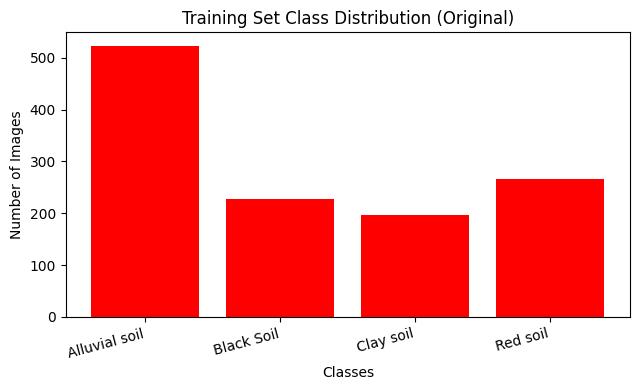

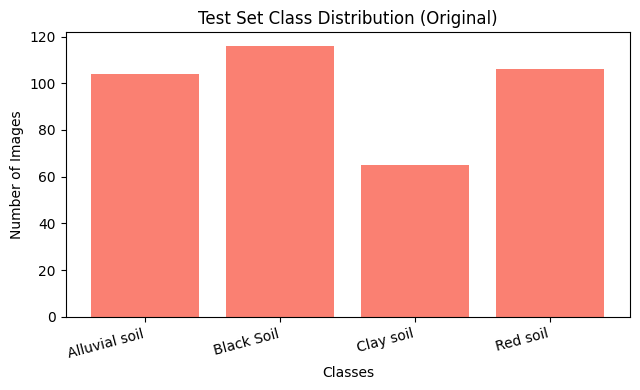


Total Train Images: 1215
Total Test Images : 391
Overall Images    : 1606


In [5]:
#count images per class in a given folder
def count_per_class(folder):
    counts = {}
    for cls in labels:
        cls_dir = os.path.join(folder, cls)
        if os.path.isdir(cls_dir):
            counts[cls] = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        else:
            counts[cls] = 0
    return counts

#plot bar chart for class distribution
def bar_counts(title, counts, color='red'):
    plt.figure(figsize=(6.5, 4))
    plt.bar(counts.keys(), counts.values(), color=color)
    plt.title(title)
    plt.xlabel('Classes'); plt.ylabel('Number of Images')
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

print("Original train counts:")
train_counts = count_per_class(TRAIN_DIR); print(train_counts)
print("Original test counts:")
test_counts = count_per_class(TEST_DIR);  print(test_counts)

bar_counts("Training Set Class Distribution (Original)", train_counts, 'red')
bar_counts("Test Set Class Distribution (Original)", test_counts, 'salmon')

total_train = sum(train_counts.values())
total_test  = sum(test_counts.values())
print(f"\nTotal Train Images: {total_train}")
print(f"Total Test Images : {total_test}")
print(f"Overall Images    : {total_train + total_test}")


Balancing to target per class = 523
Alluvial soil: already at 523
Black Soil: need 295 more images...
Clay soil: need 326 more images...
Red soil: need 256 more images...

Balanced train counts (on disk):
{'Alluvial soil': 523, 'Black Soil': 523, 'Clay soil': 516, 'Red soil': 520}


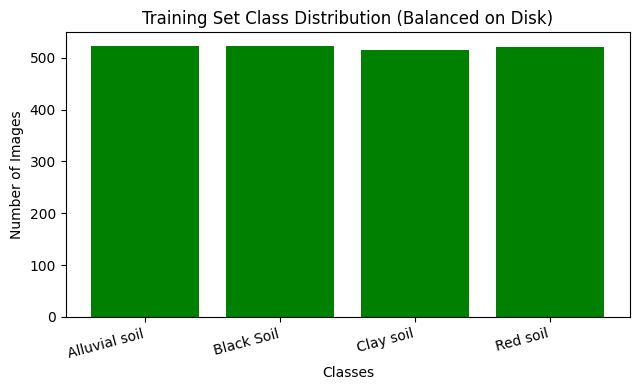

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Same augmentation settings you used (so logic stays consistent)
offline_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10
)

# Rebuild balanced folder from scratch
if os.path.exists(BAL_TRAIN_DIR):
    shutil.rmtree(BAL_TRAIN_DIR)
for cls in labels:
    os.makedirs(os.path.join(BAL_TRAIN_DIR, cls), exist_ok=True)

# 1) Copy originals into balanced dir
for cls in labels:
    src = os.path.join(TRAIN_DIR, cls)
    dst = os.path.join(BAL_TRAIN_DIR, cls)
    for fn in os.listdir(src):
        if fn.lower().endswith(('.png','.jpg','.jpeg')):
            shutil.copy2(os.path.join(src, fn), os.path.join(dst, fn))

# 2) Augment until each class reaches target = max(original counts)
target = max(train_counts.values())
print(f"\nBalancing to target per class = {target}")
for cls in labels:
    cls_dir = os.path.join(BAL_TRAIN_DIR, cls)
    cur = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    need = max(0, target - cur)
    if need == 0:
        print(f"{cls}: already at {cur}")
        continue

    print(f"{cls}: need {need} more images...")
    src_cls_dir = os.path.join(TRAIN_DIR, cls)
    src_files = [f for f in os.listdir(src_cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if not src_files:
        print(f"  (skip: no source images in {cls})")
        continue

    # Round-robin augment source images until we hit 'need'
    gen_count = 0
    idx = 0
    while gen_count < need:
        src_path = os.path.join(src_cls_dir, src_files[idx % len(src_files)])
        img = load_img(src_path, target_size=(IMG_H, IMG_W))
        arr = img_to_array(img)
        arr = np.expand_dims(arr, 0)  # (1,H,W,3)
        # Use .flow with save_to_dir to physically write augmented samples
        flow = offline_aug.flow(
            arr,
            batch_size=1,
            save_to_dir=cls_dir,
            save_prefix="aug",
            save_format="jpg",
            shuffle=False
        )
        next(flow)  # generates exactly 1 file
        gen_count += 1
        idx += 1

print("\nBalanced train counts (on disk):")
bal_counts = count_per_class(BAL_TRAIN_DIR); print(bal_counts)
bar_counts("Training Set Class Distribution (Balanced on Disk)", bal_counts, 'green')

In [47]:
trainGen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10
)
testGen = ImageDataGenerator(rescale=1./255)

train_data = trainGen.flow_from_directory(
    BAL_TRAIN_DIR,
    target_size=(IMG_H, IMG_W),
    classes=labels,      # keep class order consistent
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
test_data = testGen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_H, IMG_W),
    classes=labels,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 2082 images belonging to 4 classes.
Found 391 images belonging to 4 classes.


In [ ]:


model = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(32, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation="relu"),   # 32-dim feature layer
    Dense(4, activation="softmax")
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898,820 (3.43 MB)

 Trainable params: 898,820 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 978ms/step - accuracy: 0.6974 - loss: 0.7362
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - accuracy: 0.8180 - loss: 0.4665
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 778ms/step - accuracy: 0.8420 - loss: 0.3931
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 776ms/step - accuracy: 0.8525 - loss: 0.3652
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 771ms/step - accuracy: 0.8761 - loss: 0.3085
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 795ms/step - accuracy: 0.8713 - loss: 0.3266
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - accuracy: 0.9001 - loss: 0.2549
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 798ms/step - accuracy: 0.9203 - loss: 0.2180
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 784ms/step - accuracy: 0.9097 - loss: 0.2370
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9121 - loss: 0.2353
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9251 - loss: 0.2004
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 128s 2s

In [51]:
h = history.history
epochs = range(1, len(h['loss']) + 1)

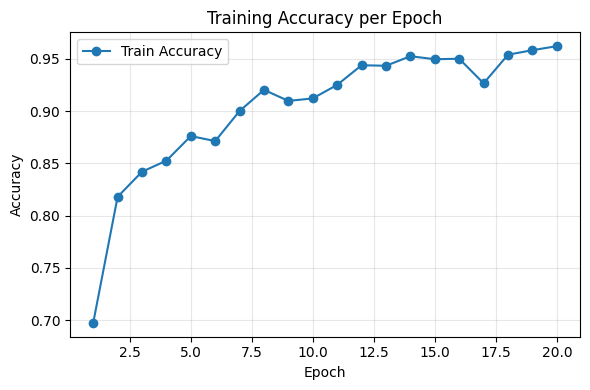

In [52]:

plt.figure(figsize=(6,4))
plt.plot(epochs, h.get('accuracy', []), marker='o', label='Train Accuracy')
plt.title('Training Accuracy per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


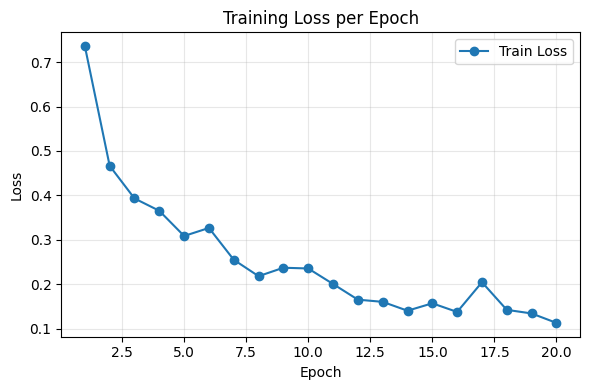

In [53]:
plt.figure(figsize=(6,4))
plt.plot(epochs, h.get('loss', []), marker='o', label='Train Loss')
plt.title('Training Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [54]:
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"\n[CNN] Test Accuracy: {test_acc*100:.2f}%")
print(f"[CNN] Test Loss    : {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9003 - loss: 0.2947

[CNN] Test Accuracy: 90.03%
[CNN] Test Loss    : 0.2947


In [ ]:


y_prob = model.predict(test_data, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

print("\n[CNN] Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step

[CNN] Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.84      0.81      0.82       104
   Black Soil       0.99      0.92      0.96       116
    Clay soil       0.81      0.89      0.85        65
     Red soil       0.93      0.97      0.95       106

     accuracy                           0.90       391
    macro avg       0.89      0.90      0.89       391
 weighted avg       0.90      0.90      0.90       391



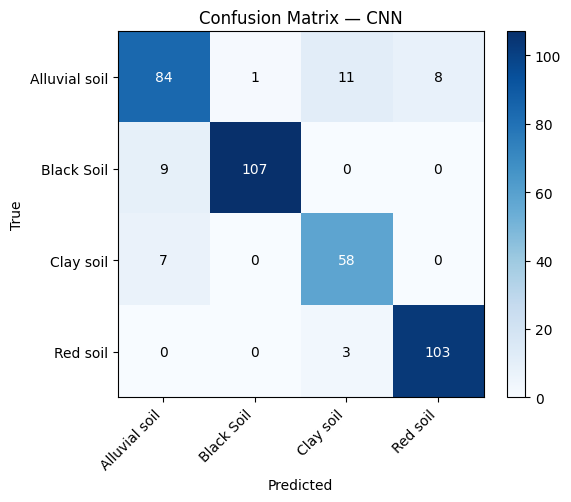

In [56]:
cm = confusion_matrix(y_true, y_pred)   
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix — CNN")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

In [ ]:
featGen = ImageDataGenerator(rescale=1./255)

train_feat_gen = featGen.flow_from_directory(
    BAL_TRAIN_DIR,                      # your balanced train folder
    target_size=(IMG_H, IMG_W),
    classes=labels,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False                       # <<< IMPORTANT
)

test_feat_gen = featGen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_H, IMG_W),
    classes=labels,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)-

Found 2082 images belonging to 4 classes.
Found 391 images belonging to 4 classes.


In [59]:
_ = model(np.zeros((1, IMG_H, IMG_W, 3), dtype=np.float32))

In [60]:
# --- 2) (optional) verify layer order so we pick the right index
for i, l in enumerate(model.layers):
    print(i, l.name, l.__class__.__name__)

0 conv2d_3 Conv2D
1 max_pooling2d_3 MaxPooling2D
2 conv2d_4 Conv2D
3 max_pooling2d_4 MaxPooling2D
4 dropout_2 Dropout
5 conv2d_5 Conv2D
6 max_pooling2d_5 MaxPooling2D
7 dropout_3 Dropout
8 flatten_1 Flatten
9 dense_2 Dense
10 dense_3 Dense


In [61]:
# So Flatten is the third from the end: layers[-3]
flatten_layer = model.layers[-3]
assert isinstance(flatten_layer, Flatten), f"Expected Flatten at -3, got {type(flatten_layer)}"

In [62]:
# --- 3) Build the feature extractor ending at Flatten
feature_extractor = Model(inputs=model.inputs, outputs=flatten_layer.output)

In [63]:
train_feat_gen.reset()
X_train_flat = feature_extractor.predict(train_feat_gen, verbose=1)
y_train = train_feat_gen.classes

66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step


In [64]:
test_feat_gen.reset()
X_test_flat  = feature_extractor.predict(test_feat_gen,  verbose=1)
y_test  = test_feat_gen.classes
print("Flatten features:", X_train_flat.shape, X_test_flat.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step
Flatten features: (2082, 25088) (391, 25088)


In [66]:
param_grid = {
    "pca__n_components": [96, 128, 160, 192, 256],
    "pca__whiten": [False, True],
    "svm__C": [5, 10, 50],
    "svm__gamma": ["scale", 0.01, 0.005, 0.001],
}


In [67]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_flat.astype("float32"), y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'pca__n_components': [96, 128, ...], 'pca__whiten': [False, True], 'svm__C': [5, 10, ...], 'svm__gamma': ['scale', 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [68]:
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)

Best params: {'pca__n_components': 96, 'pca__whiten': False, 'svm__C': 50, 'svm__gamma': 'scale'}
Best CV acc: 0.962536023054755


In [69]:
best = grid.best_estimator_
pred = best.predict(X_test_flat.astype("float32"))
print(f"Test acc: {accuracy_score(y_test,pred)*100:.2f}%")
print(classification_report(y_test, pred, target_names=labels))

Test acc: 95.40%
               precision    recall  f1-score   support

Alluvial soil       1.00      0.85      0.92       104
   Black Soil       0.99      1.00      1.00       116
    Clay soil       0.86      1.00      0.92        65
     Red soil       0.95      0.98      0.96       106

     accuracy                           0.95       391
    macro avg       0.95      0.96      0.95       391
 weighted avg       0.96      0.95      0.95       391



<Figure size 600x500 with 0 Axes>

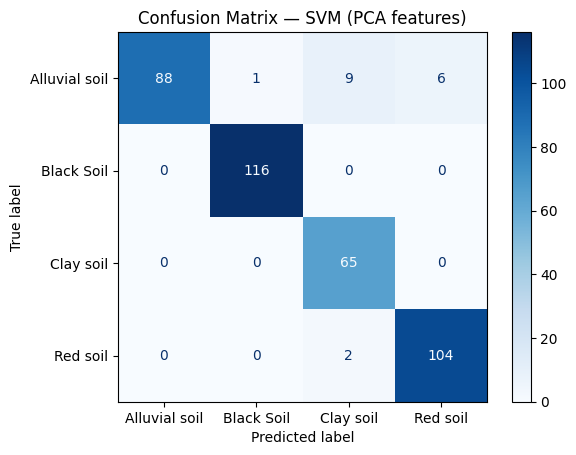

In [70]:
cm = confusion_matrix(y_test, pred)

# --- Display ---
plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", colorbar=True, values_format='d')
plt.title("Confusion Matrix — SVM (PCA features)")
plt.show()

In [ ]:

# labels must match your training order
# labels = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']

def predict_one(img_path):
    """Predict a single image with CNN->Flatten features then PCA+SVM (grid.best_estimator_)."""
    # 1) Load & preprocess
    img = image.load_img(img_path, target_size=(IMG_H, IMG_W))
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    # 2) Extract Flatten features
    feats = feature_extractor.predict(arr, verbose=0)  # shape (1, 25088)

    # 3) Run through tuned pipeline (scaler -> PCA -> SVM)
    best_pipe = grid.best_estimator_
    probs = best_pipe.predict_proba(feats)[0]          # shape (4,)
    pred_idx = int(np.argmax(probs))
    pred_class = labels[pred_idx]
    conf = probs[pred_idx] * 100.0

    # 4) Show & print
    plt.imshow(img); plt.axis("off")
    plt.title(f"Predicted: {pred_class} ({conf:.2f}%)")
    plt.show()

    print("Class probabilities:")
    for cls, p in zip(labels, probs):
        print(f"  {cls:<15}: {p*100:.2f}%")

    return pred_class, conf

# Example:
# 


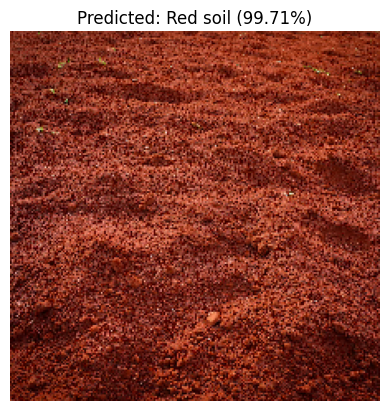

Class probabilities:
  Alluvial soil  : 0.09%
  Black Soil     : 0.17%
  Clay soil      : 0.03%
  Red soil       : 99.71%


('Red soil', np.float64(99.71410785362397))

In [72]:
predict_one("red.jpg")

In [ ]:
# ===== SAVE ARTIFACTS for the Flask app =====
import json, joblib, numpy as np

# 1) Save CNN (keras format) — we’ll rebuild the Flatten extractor inside the app
model.save("cnn_model.keras")

# 2) Save tuned pipeline (StandardScaler → PCA → SVM) as one object
best_pipe = grid.best_estimator_
joblib.dump(best_pipe, "pca_svm_pipeline.pkl")

# 3) Save labels (order matters!)
with open("labels.json", "w") as f:
    json.dump({"labels": labels}, f, indent=2)

# 4) AUTO-SET OOD / “Unknown” thresholds from your test set
#    (conservative: reject the lowest-confidence 10% of correct preds)
probs_test = best_pipe.predict_proba(X_test_flat.astype("float32"))
top2_sorted = np.sort(probs_test, axis=1)[:, -2:]
max_prob = top2_sorted[:, 1]
margin   = top2_sorted[:, 1] - top2_sorted[:, 0]
entropy  = (-probs_test * np.log(probs_test + 1e-12)).sum(axis=1)

def pct(x, p): return float(np.percentile(x, p))

thresholds = {
    # If max prob falls below this → Unknown
    "max_prob_tau": pct(max_prob, 10),     # e.g., ~0.90–0.95 typically
    # If (top1 - top2) margin is small → Unknown
    "margin_tau":   pct(margin,   10),
    # If entropy is high (uncertain) → Unknown
    "entropy_tau":  pct(entropy,  90)
}
with open("thresholds.json", "w") as f:
    json.dump(thresholds, f, indent=2)

print("Saved: cnn_model.keras, pca_svm_pipeline.pkl, labels.json, thresholds.json")
print("Thresholds:", thresholds)


Saved: cnn_model.keras, pca_svm_pipeline.pkl, labels.json, thresholds.json
Thresholds: {'max_prob_tau': 0.9062949480539781, 'margin_tau': 0.8568846175840784, 'entropy_tau': 0.38361078015670047}
